In [139]:
%config InlineBackend.figure_format = 'svg' # change output plot display format to 'svg'

# import the required modules for this notebook
import numpy
import matplotlib.pyplot as plt

# import the helper functions from the parent directory,
# these help with things like graph plotting and notebook layout
import sys
sys.path.append('..')
from helper_functions import *

# set things like fonts etc - comes from helper_functions
set_notebook_preferences()

# add a show/hide code button - also from helper_functions
toggle_code(title = "setup code")

## Overfitting in classification

We have previously encountered [linear classification models](classification_logistic_regression_model.ipynb) and their [non-linear generalisation](classification_non-linear.ipynb). Both the linear and non-linear variants of these models can overfit to the training data. You may have noticed signs of this on some of the examples previously presented. In this section we will look at a couple of clear examples of this phenomenum using test-train splits to diagnose the problem as we did for [regression](../regression/regression_overfitting.ipynb).

### Example 1: Overfitting in linear binary logistic classification

Although over-fitting is most problematic for non-linear models, it can still occur in linear models. The 2D Iris dataset we have used before is shown below with the data split into 75% for training and 25% for testing.

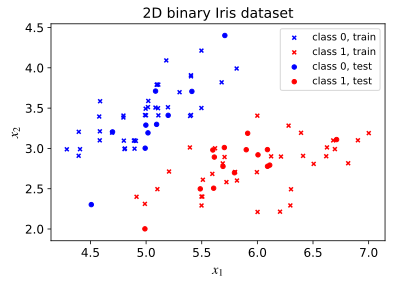

In [140]:
x = np.load('iris_inputs_full.npy')
y = np.load('iris_labels.npy')

x = x[np.where(np.logical_not(y == 2))[0]] 
y = y[np.where(np.logical_not(y == 2))[0]] # removing the datapoints of class 2

x = x[:,0:2] 

ax = plt.subplot(1,1,1)
no_test = (x.shape[0]*1)//4
x_test, x_train, y_test, y_train = x[:no_test], x[no_test:], y[:no_test], y[no_test:]

class_0_train, class_1_train = np.where(y_train == 0), np.where(y_train == 1)
plt.scatter(x_train[class_0_train, 0], x_train[class_0_train, 1], color = 'blue', marker = 'x', s = 15,label='class 0, train')
plt.scatter(x_train[class_1_train, 0], x_train[class_1_train, 1], color = 'red', marker = 'x', s = 15,label='class 1, train')

class_0_test, class_1_test = np.where(y_test == 0), np.where(y_test == 1)


plt.scatter(x_test[class_0_test, 0], x_test[class_0_test, 1], color = 'blue', marker = 'o', s = 20,label='class 0, test')
plt.scatter(x_test[class_1_test, 0], x_test[class_1_test, 1], color = 'red', marker = 'o', s =20,label='class 1, test')
ax.legend()
beautify_plot({"title":r"2D binary Iris dataset", "x":"$x_1$", "y":"$x_2$"})
plt.show()


toggle_code(title = "2D Iris Dataset", on_load_hide = True)

We will now run the code that fits the model using maximum-likelihood estimation through gradient ascent. Before running the code, take a moment to consider the following questions:

1. **Where will the decision boundary lie after running many iterations?** 
2. **What will the magnitude of the weights be?**
3. **What will be the held out log-likelihood of the resulting model** i.e. $\prod_{n=1}^{N_{\text{test}}} p(y_n^{\ast} | \mathbf{w},x_n^{\ast})$?

If the answer to this questions is not obvious, you may like to experiment with the code to allow, varying the number of iterations to form a picture about what's happening. 

In [141]:
def sig(x):
    
    return 1/(1 + np.exp(-x)) # define logistic function for convenience

def gradient_ascent(x, y, x_test, y_test, init_weights, no_steps, stepsize): # x: train inputs, y: train labels, rest self explanatory
    
    x = np.append(np.ones(shape = (x.shape[0], 1)), x, axis = 1) # add 1's to the inputs as usual
    x_test = np.append(np.ones(shape = (x_test.shape[0], 1)), x_test, axis = 1) # add 1's to the inputs as usual
    
    w = init_weights.copy() # copy weights (to prevent changing init_weights as a side-effect - don't dwell on this)
    
    w_history, log_liks, log_liks_test = [],[],[] # arrays for storing weights and log-liklihoods at each step
    
    for n in range(no_steps): # in this part we optimise log-lik w.r.t. w
        
        log_liks.append(np.sum(y * np.log(sig(x.dot(w))) + (1 - y) * np.log(1 - sig(x.dot(w))))) # record current log-lik
        log_liks_test.append(np.sum(y_test * np.log(sig(x_test.dot(w))) + (1 - y_test) * np.log(1 - sig(x_test.dot(w))))) # record current log-lik

        w_history.append(w.copy()) # record current weights (use w.copy() to prevent aliasing - don't dwell on this)
    
        sigs = sig(x.dot(w)) # using our neat convenience function
        
        dL_dw = np.mean((y - sigs)*x.T, axis = 1) # calculate gradient of log-likelihood w.r.t. w
        
        w += stepsize * dL_dw # update weights and repeat
    
    return np.array(w_history), np.array(log_liks), np.array(log_liks_test)

toggle_code(title = "Logistic and gradient ascent function", on_load_hide = True)



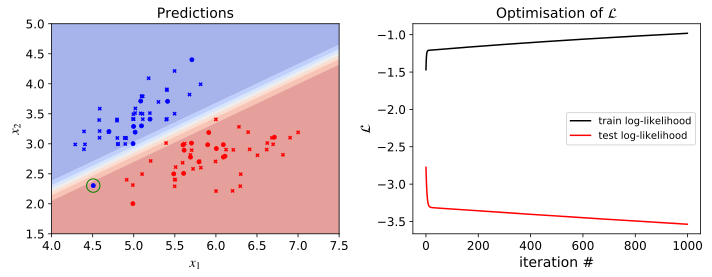

Final training log-likelihood = -0.98 nats
Final test log-likelihood = -3.54 nats


In [142]:
w_init = [-4,7,-11]  # use a good initialisation to speed up simulation: 
                      # there is a unique optimum, so poorer initialisations will just entail waiting for longer

w_history, log_liks_train, log_liks_test = gradient_ascent(x_train, y_train, x_test, y_test, w_init, 1000, 0.5)

x1 = np.linspace(4, 7.5, 100)
x2 = np.linspace(1.5, 5, 100)

test_grid = np.stack(np.meshgrid(x1, x2), axis = 2).reshape((-1, 2))

test_grid = np.append(np.ones(shape = (test_grid.shape[0], 1)), test_grid, axis = 1)

pred = sig(test_grid.dot(w_history[-1])).reshape(100, 100)


fig=plt.figure(figsize=(10, 4), dpi= 80)


plt.subplot(1,2,1)
plt.contourf(x1, x2,pred, cmap = 'coolwarm', alpha = 0.5, origin = 'lower')
plt.scatter(x_train[class_0_train, 0], x_train[class_0_train, 1], color = 'blue', marker = 'x', s = 10)
plt.scatter(x_train[class_1_train, 0], x_train[class_1_train, 1], color = 'red', marker = 'x', s = 10)

plt.scatter(x_test[class_0_test, 0], x_test[class_0_test, 1], color = 'blue', marker = 'o', s = 15)
plt.scatter(x_test[class_1_test, 0], x_test[class_1_test, 1], color = 'red', marker = 'o', s = 15)
beautify_plot({"title":r"Predictions", "x":"$x_1$", "y":"$x_2$"})
plt.scatter([4.50747563], [2.30301912], color = 'green', marker = 'o', s = 180,facecolors='none')


ax2 = plt.subplot(1,2,2)
plt.plot(log_liks_train, color = 'black',label='train log-likelihood')
plt.plot(log_liks_test, color = 'red',label='test log-likelihood')
beautify_plot({"title":r"Optimisation of $\mathcal{L}$", "x":"iteration #", "y":"$\mathcal{L}$"})
ax2.legend()

fig.tight_layout()
plt.show()

x = np.arange(10)

print("Final training log-likelihood = {0:.2f} nats".format(log_liks_train[-1]))
print("Final test log-likelihood = {0:.2f} nats".format(log_liks_test[-1]))


toggle_code(title = "2D overfitting example", on_load_hide = True)



The training data above are linearly separable. For this reason there are a set of maximum-likelihood solutions. Each solution places the linear decision boundary so that it divides the two classes (there are many ways to do this) and then makes the logistic function as steep as possible - i.e. a step function - so that the probability of each datapoint goes to 1 and the training log-likelihood goes to zero. Numerical problems may be encountered before this limit is reached as this behaviour causes the magnitude of the weights to go to infinity. 

Whilst the training likelihood of the maximum-likelihood solution is one, the test likelihood is zero. The blue test point in the bottom left (indicated by a green circle) is classified as being in class 1 which is incorrect. Worse still, it makes this prediction with probability 1 as the point is below the hard decision boundary, which zeros the likelihood. 

Clearly this is an instance of overfitting as the training likelihood is as high as it can possibly be and the test log-likelihood is as low as it can possibly be. The model is overconfident. Notice that this behaviour is very likely to happen for small numbers of datapoints which will often be linearly separable by chance. 

### Example 2: Overfitting in non-linear binary logistic classification

Let's consider a second example. Here we will use the 1D dataset below. 

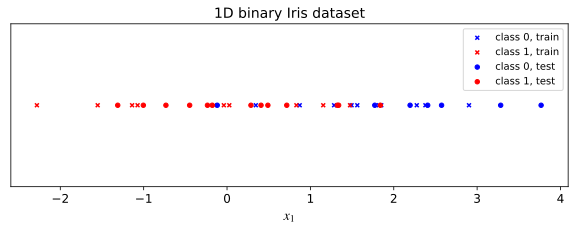

In [143]:
x = np.load('class_1d_inputs.npy')
y = np.load('class_1d_labels.npy')

x_train, x_test, y_train, y_test = x[:20], x[20:], y[:20], y[20:]

class_0_train, class_1_train = np.where(y_train == 0), np.where(y_train == 1)

fig=plt.figure(figsize=(10, 3), dpi= 80)
ax = plt.subplot(1,1,1)

plt.scatter(x_train[class_0_train,0], np.ones((1,np.size(class_0_train))), color = 'blue', marker = 'x', s = 15,label='class 0, train')
plt.scatter(x_train[class_1_train, 0], np.ones((1,np.size(class_1_train))), color = 'red', marker = 'x', s = 15,label='class 1, train')

class_0_test, class_1_test = np.where(y_test == 0), np.where(y_test == 1)


plt.scatter(x_test[class_0_test, 0], np.ones((1,np.size(class_0_test))), color = 'blue', marker = 'o', s = 20,label='class 0, test')
plt.scatter(x_test[class_1_test, 0], np.ones((1,np.size(class_1_test))), color = 'red', marker = 'o', s =20,label='class 1, test')
ax.legend()
ax.get_yaxis().set_ticks([])

beautify_plot({"title":r"1D binary Iris dataset", "x":"$x_1$"})
plt.show()

toggle_code(title = "1D Iris Dataset", on_load_hide = True)

We will now fit a non-linear logistic classification model. We will use 100 Gaussian basis functions $\phi_{d}(x) = \exp(-\frac{1}{2 l^2} ( \mathbf{x} - \mu_{d})^2)$ evaluating the test and training likelihoods for  basis function length-scales  that range from $l=0.1$ to $l=3$. 

**What do you expect the plot of the two likelihood functions to look like?**
**What will happen to the model at the long length-scales?**
**What will happen at the model at the short length-scales?**

WARNING: this code takes a little while to run as it is fitting many models.

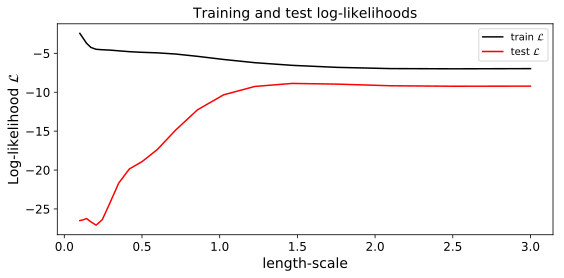

In [144]:
no_lengthscales = 20
lengthscales = np.logspace(np.log10(3),np.log10(0.1),no_lengthscales)
no_basis = 100
mu = np.linspace(-2.5, 4.0, no_basis)

N_train = y_train.size
N_test = y_test.size
ll_test = np.zeros((no_lengthscales,1))
ll_train = np.zeros((no_lengthscales,1))                   


for l in range(no_lengthscales):
        
    lengthscale = lengthscales[l]
    phi_train = np.zeros((N_train,no_basis))
    phi_test = np.zeros((N_test,no_basis))

    for n in range(N_train):
        for d in range(no_basis):   
            phi_train[n,d] = np.exp(-1/(2*lengthscale**2)*(mu[d] - x_train[n])**2)

    for n in range(N_test):
        for d in range(no_basis):   
            phi_test[n,d] = np.exp(-1/(2*lengthscale**2)*(mu[d] - x_test[n])**2)

    w_init = np.zeros(shape = (no_basis + 1,))
     
    w_history, log_liks_train, log_liks_test = gradient_ascent(phi_train, y_train, phi_test, y_test, w_init, 5000, 0.1)

    ll_test[l] = log_liks_test[-1]
    ll_train[l] = log_liks_train[-1]
                    
plt.figure(figsize = (8, 4))
plt.subplot(1, 1, 1)
plt.plot(lengthscales,ll_train, color = 'black',label='train $\mathcal{L}$') # plot train log likelihoods\
plt.plot(lengthscales,ll_test, color = 'red',label='test $\mathcal{L}$') # plot test log likelihoods
beautify_plot({"title":r"Training and test log-likelihoods", "x":"length-scale", "y":"Log-likelihood $\mathcal{L}$"})
plt.gca().legend()
plt.tight_layout()
plt.show()
toggle_code(title = "Test and train log-likelihoods on the 1D Iris Dataset", on_load_hide = True)



Notice the following:

1. **For small length-scales the training log-likelihood is at its highest**. As the length-scale is increased the training log-likelihood monotonically decreases. 

2. The test log-likelihood is always below the training log-likelihood. This is typical for any inferential procedure (even for Bayesian inference) as the model has been directly fit to the training data, so the predictions on these data are almost bound to be best. 

3. **For small length-scales the test log-likelihood is at its lowest**. As the length-scale is increased the test log-likelihood increases to a maximum around $l=1.5$ and thereafter decreases slightly.

Let's try and understand this behaviour. Let's start by plotting the fit at the maximum of the **test likelihood** of the length-scale  $l\approx 1.5$:

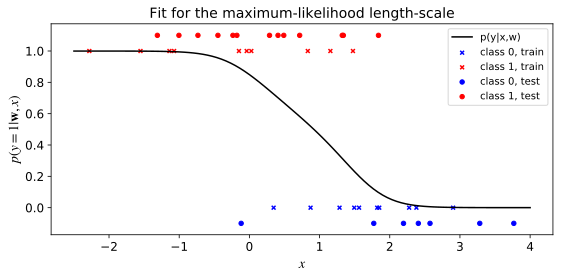

Final training log-likelihood = -6.58 nats
Final test log-likelihood = -8.86 nats


In [145]:
lengthscale = 1.5
no_basis = 100

mu = np.linspace(-2.5, 4.0, no_basis)

N_train = y_train.size
N_test = y_test.size

phi_train = np.zeros((N_train,no_basis))
phi_test = np.zeros((N_test,no_basis))

for n in range(N_train):
    for d in range(no_basis):   
        phi_train[n,d] = np.exp(-1/(2*lengthscale**2)*(mu[d] - x_train[n])**2)

for n in range(N_test):
    for d in range(no_basis):   
        phi_test[n,d] = np.exp(-1/(2*lengthscale**2)*(mu[d] - x_test[n])**2)

w_init = np.zeros(shape = (no_basis + 1,))
     
w_history, log_liks_train, log_liks_test = gradient_ascent(phi_train, y_train, phi_test, y_test, w_init, 5000, 0.1)

plt.figure(figsize = (8, 4))

plt.subplot(1, 1, 1)
N_eval = 100;
xs = np.linspace(mu[0],mu[-1],N_eval)

phi_eval = np.zeros((N_eval,no_basis))
for n in range(N_eval):
    for d in range(no_basis):   
        phi_eval[n,d] = np.exp(-1/(2*lengthscale**2)*(mu[d] - xs[n])**2)

phi_eval = np.append(np.ones(shape = (phi_eval.shape[0], 1)), phi_eval, axis = 1) # add 1's to the inputs as usual

plt.scatter(x_train[class_0_train,0], 0*np.ones((1,np.size(class_0_train))), color = 'blue', marker = 'x', s = 15,label='class 0, train')
plt.scatter(x_train[class_1_train, 0], 1*np.ones((1,np.size(class_1_train))), color = 'red', marker = 'x', s = 15,label='class 1, train')


plt.plot(xs, sig(phi_eval.dot(w_history[-1,:])), color = 'black', zorder = 3, label = 'p(y|x,w)')
plt.scatter(x_test[class_0_test, 0], -0.1*np.ones((1,np.size(class_0_test))), color = 'blue', marker = 'o', s = 20,label='class 0, test')
plt.scatter(x_test[class_1_test, 0], 1.1*np.ones((1,np.size(class_1_test))), color = 'red', marker = 'o', s =20,label='class 1, test')

beautify_plot({"title":r"Fit for the maximum-likelihood length-scale", "x":"$x$", "y":"$p(y = 1|\mathbf{w}, x)$"})
plt.gca().legend()
plt.tight_layout()
plt.show()

print("Final training log-likelihood = {0:.2f} nats".format(log_liks_train[-1]))
print("Final test log-likelihood = {0:.2f} nats".format(log_liks_test[-1]))

toggle_code(title = "Maximum likelihood length-scale", on_load_hide = True)



Here we have separated the test and the train data to help assess the model. This looks like a reasonable fit that takes into account the indistinct bounday between the two classes. Plots for larger length-scales look similar to this, but they over-smooth the boundary slightly, reducing the associated test likelihood. 

Now let's find out what's happening at those very low length-scales which actually **maximise the training likelihood** by plotting the fit for $l=0.1$:

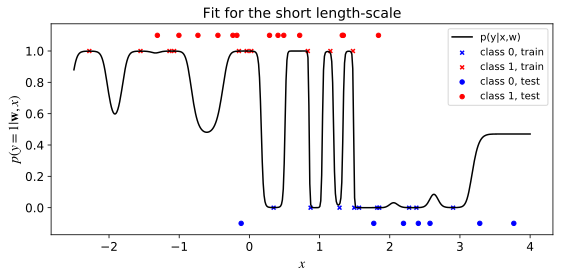

Final training log-likelihood = -0.44 nats
Final test log-likelihood = -37.61 nats


In [146]:
lengthscale = 0.1 # you may need to alter the learning rate and the number of iterations if you change this value 
no_basis = 100

mu = np.linspace(-2.5, 4.0, no_basis)

N_train = y_train.size
N_test = y_test.size

phi_train = np.zeros((N_train,no_basis))
phi_test = np.zeros((N_test,no_basis))

for n in range(N_train):
    for d in range(no_basis):   
        phi_train[n,d] = np.exp(-1/(2*lengthscale**2)*(mu[d] - x_train[n])**2)

for n in range(N_test):
    for d in range(no_basis):   
        phi_test[n,d] = np.exp(-1/(2*lengthscale**2)*(mu[d] - x_test[n])**2)

w_init = np.zeros(shape = (no_basis + 1,))
     
w_history, log_liks_train, log_liks_test = gradient_ascent(phi_train, y_train, phi_test, y_test, w_init, 5000, 2)

plt.figure(figsize = (8, 4))

plt.subplot(1, 1, 1)
N_eval = 500;
xs = np.linspace(mu[0],mu[-1],N_eval)

phi_eval = np.zeros((N_eval,no_basis))
for n in range(N_eval):
    for d in range(no_basis):   
        phi_eval[n,d] = np.exp(-1/(2*lengthscale**2)*(mu[d] - xs[n])**2)

phi_eval = np.append(np.ones(shape = (phi_eval.shape[0], 1)), phi_eval, axis = 1) # add 1's to the inputs as usual

plt.scatter(x_train[class_0_train,0], 0*np.ones((1,np.size(class_0_train))), color = 'blue', marker = 'x', s = 15,label='class 0, train')
plt.scatter(x_train[class_1_train, 0], 1*np.ones((1,np.size(class_1_train))), color = 'red', marker = 'x', s = 15,label='class 1, train')


plt.plot(xs, sig(phi_eval.dot(w_history[-1,:])), color = 'black', zorder = 3, label = 'p(y|x,w)')
plt.scatter(x_test[class_0_test, 0], -0.1*np.ones((1,np.size(class_0_test))), color = 'blue', marker = 'o', s = 20,label='class 0, test')
plt.scatter(x_test[class_1_test, 0], 1.1*np.ones((1,np.size(class_1_test))), color = 'red', marker = 'o', s =20,label='class 1, test')

beautify_plot({"title":r"Fit for the short length-scale", "x":"$x$", "y":"$p(y = 1|\mathbf{w}, x)$"})
plt.gca().legend()
plt.tight_layout()
plt.show()

print("Final training log-likelihood = {0:.2f} nats".format(log_liks_train[-1]))
print("Final test log-likelihood = {0:.2f} nats".format(log_liks_test[-1]))

toggle_code(title = "Short length-scale", on_load_hide = True)

We can now see the source of the bad behaviour: the model is contorting itself so that it assigns a probability that is close to one for each of the training points. The model can now do this as the length-scale of the basis functions is very shot. The predictions on the test data are poor. This is second example of over-fitting and an example of **a failure of maximum likelihood training**. 

### Summary

Overfitting occurs in classification when the model can contort itself to assign probability one to each training datapoint. This then results in confident predictions that are often wrong when evaluated on the test set. This behaviour can manifest itself in different ways depending on the data, model, and the method of fitting the parameters:

1. Linear classification methods trained by maximising the training likelihood will overfit in cases where the training data classes are perfectly separable by a linear decision boundary. 
2. Non-linear logistic classification with RBF basis functions trained by maximising the training likelihood will overfit when a large number of basis functions are used and the length-scales are short. The resulting model will be overl complex.

Overfitting can be identified using train / test splits of the data. When the training likelihood is increasing and the test likelihood is decreasing it is likely that overfitting is occurring.

In [section 3.5](classification_regularisation.ipynb) we will look at using MAP inference, rather than maximum likelihood estimation, can regularise the solution and mitigate overfitting.

### Questions

**1. Extrapolation in radial basis function logistic classification**

Consider the second example above where radial basis functions $\phi_{d}(x) = \exp(-\frac{1}{2 l^2} ( \mathbf{x} - \mu_{d})^2)$ with length-scale $l$ were used for non-linear logisitic classification. A test point lies five length-scales away from its closest training point. 

a) Estimate the prediction at this point $p(y_n^{\ast} = 1 | \mathbf{w},x_n^{\ast})$. 

b) Would this estimate change if a basis-functions were placed in this region? 

c) What implications does this have for the ability of this model to generalise away from the training data?

You can, of course, alter the code if this helps to answer these questions.

<details>
<summary>Answer</summary>
<div>
a) Let's consider the situation where the basis functions are only located in the region of the training data. After 5 length-scales the closest radial basis function to the test point has fallen to $\exp(-25/2) \approx 5 \times 10^{-6}$ and so the training data provide essentially no useful information about this region of input space and the prediction is $p(y_n^{\ast} = 1 | \mathbf{w},x_n^{\ast}) \approx 1/2$. <br><br>

b) Even if basis functions are placed around the the test point, since each training datapoint only provides information about the weights on radial basis functions that are 'close' to them, the weights of RBFs around the test datapoint will remain at whatever value they are initialised at: the predictions at the training data are not affected by their value.<br><br>

c) Models that employ radial basis functions can only generalise one or two length-scales outside the region of the training data. You can think of these models as simply smoothing the data. This observation is the motivation for considering richer classes of basis function that can be learned from data. Neural networks can be viewed through this lens. 


</div>
</details>

</div>
</details>
